In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p):
    _, axs = plt.subplots(3, 2,figsize=(15,10))

    axs[0][0].plot(parameters, avg_t_t)
    axs[0][0].set_title('Среднее время нахождения в очереди')

    axs[0][1].plot(parameters, lost_cust_p)
    axs[0][1].set_title('Вероятность отказа')

    axs[1][0].plot(parameters, waiting_cust_p)
    axs[1][0].set_title('Вероятность ожидания')

    axs[1][1].plot(parameters, avg_len)
    axs[1][1].set_title('Средняя длина очереди')

    axs[2][0].plot(parameters, wasted_t_p)
    axs[2][0].set_title('Вероятность простоя системы')


In [34]:
def get_poisson_time(param):
    s = 0
    while s == 0:
        s = np.random.poisson(param)
    return s


def MM1Ksimulation(capacity = 1, lmbd = 1, mu = 1, timeout = 1):
    assert capacity, "Max length of queue should be greater than 0"
    assert lmbd and mu, "Your model parameters lambda and mu should be greater than 0"
    assert timeout, "Your experiment time should be greater than 0"

    queue, arrival_time, departure_time, num_in_q, waiting_time, wasted_time = [], [], [], [], [], []
    total_customers, lost_customers, total_served, waiting_customers = 0, 0, 0, 0

    # Compute time of next arrival.
    nextArrival = get_poisson_time(lmbd)

    # Compute time of next completed service.
    nextService = nextArrival + get_poisson_time(mu)

    # Simulate the M/M/1 queue.
    timeout_start = time.time() 
    while time.time() < timeout_start + timeout:
        # Next event is an arrival.
        while nextArrival < nextService:
            # Simulate an arrival
            if len(queue) < capacity:
                queue.append(nextArrival)
                arrival_time.append(nextArrival)
                total_customers += 1
                num_in_q.append(len(queue))
                if(len(queue)):
                    waiting_customers += 1      
            else:
                lost_customers  += 1
                total_customers += 1
            nextArrival += get_poisson_time(lmbd)

        # Next event is a service completion.
        arrival = queue.pop(0)
        total_served += 1
        departure_time.append(nextService)
        waiting_time.append(nextService - arrival)
        num_in_q.append(len(queue))

        # Update the queue.
        if not queue:
            nextService = nextArrival + get_poisson_time(mu)
        else:
            nextService = nextService + get_poisson_time(mu)
    num_of_customers = len(arrival_time)
    arrival_time = arrival_time[:len(departure_time)]
    
    for i in range(1, len(departure_time)):
        if ((arrival_time[i]-departure_time[i-1])>0):
            wasted_time.append(arrival_time[i]-departure_time[i-1])
    return      np.mean(waiting_time),              \
                lost_customers/total_customers,     \
                waiting_customers/num_of_customers, \
                np.mean(num_in_q),                  \
                sum(wasted_time)/departure_time[-1]

Just use

In [35]:
avg_total_time,         \
lost_customers_prob,    \
waiting_customers_prob, \
avg_num_in_q,           \
wasted_time_prob        = MM1Ksimulation(capacity = 1, lmbd = 0.003, mu = 0.01, timeout = 1)
print("Среднее время пребывания в системе",avg_total_time)
print("Вероятность ухода посетителя",lost_customers_prob)
print("Вероятность ожидания", waiting_customers_prob)
print("Среднее количество людей в очереди",avg_num_in_q)
print("Вероятность простоя системы",wasted_time_prob)

Среднее время пребывания в системе 1.0057123655913978
Вероятность ухода посетителя 0.005679919812896759
Вероятность ожидания 1.0
Среднее количество людей в очереди 0.5
Вероятность простоя системы 0.0016672224074691564


**lambda = mu**

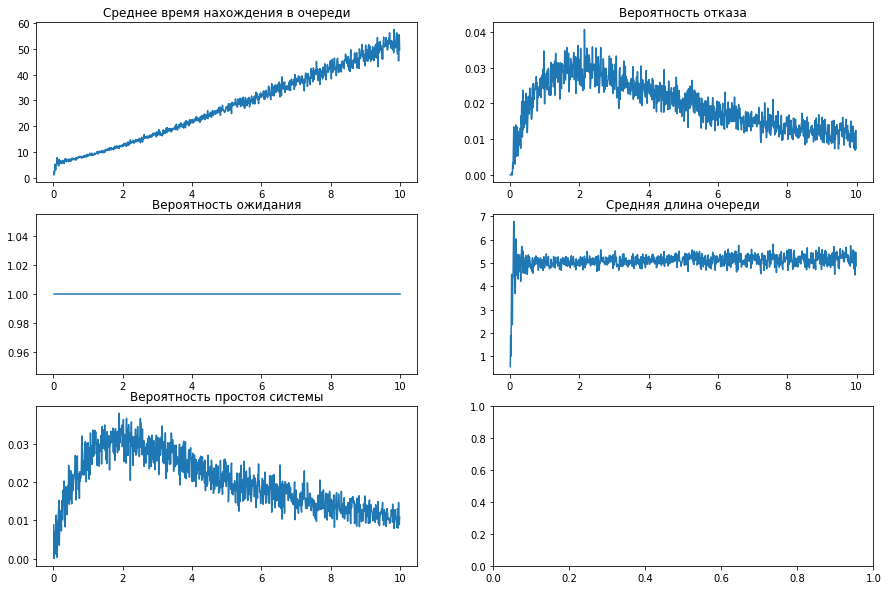

In [36]:
avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p = [], [], [], [], []

parameters = np.arange(0.01, 10, 0.01)
for mu in parameters:
    lmbd = mu
    np.random.seed(int(lmbd*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(capacity = 10, lmbd = lmbd, mu = mu, timeout = 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p)

**lambda<mu**

In [37]:
avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p =[], [], [], [], []
mu = 5
parameters = np.arange(0.01, mu/2, 0.01)
for lmbd in parameters:
    np.random.seed(int(lmbd*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(capacity = 10, lmbd = lmbd, mu = mu, timeout = 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p)

Error in callback <function flush_figures at 0x000002A5F8A164C0> (for post_execute):


KeyboardInterrupt: 

**lambda>mu**

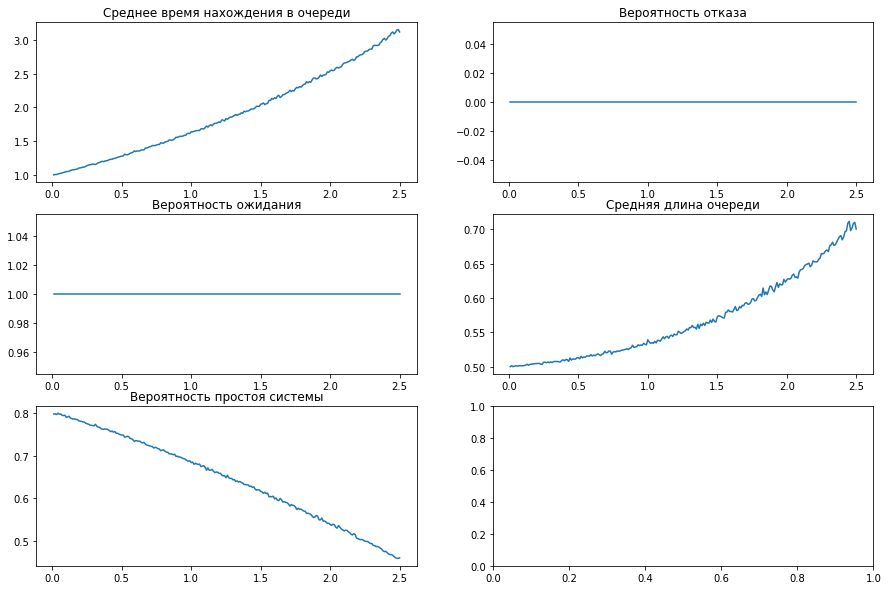

In [ ]:
#metrics
avg_t_t,lost_cust_p,waiting_cust_p,avg_len,wasted_t_p =[],[],[],[],[]
lmbd = 5
parameters = np.arange(0.01, lmbd/2, 0.01)
for mu in parameters:
    np.random.seed(int(mu*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(10, lmbd, mu, 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p)

**Зафиксируем lambda=5 и mu=2.5 и проведем эксперименты с различными длинами очереди**

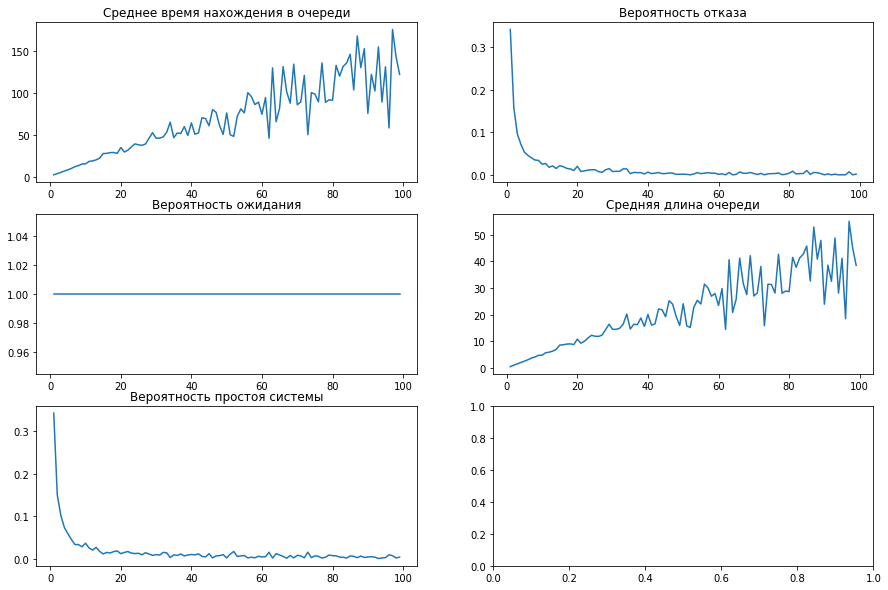

In [ ]:
#metrics
avg_t_t,lost_cust_p,waiting_cust_p,avg_len,wasted_t_p =[],[],[],[],[]
capacity = 100
parameters = np.arange(1, capacity, 1)
for cap in parameters:
    np.random.seed(int(cap*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(cap, 3, 3, 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)
    
print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p)

In [ ]:
def get_poisson_time(param):
    s = 0
    while s == 0:
        s = np.random.poisson(param)
    return s


def MM1Ksimulation(capacity = 1, lmbd = 1, mu = 1, timeout = 1):
    assert capacity, "Max length of queue should be greater than 0"
    assert lmbd and mu, "Your model parameters lambda and mu should be greater than 0"
    assert timeout, "Your experiment time should be greater than 0"

    queue, arrival_time, departure_time, num_in_q, waiting_time, wasted_time = [], [], [], [], [], []
    total_customers, lost_customers, total_served, waiting_customers = 0, 0, 0, 0

    # Compute time of next arrival.
    nextArrival = get_poisson_time(lmbd) #16

    # Compute time of next completed service.
    nextService = nextArrival + get_poisson_time(mu)# 16+15

    #print(nextArrival, nextService)

    # Simulate the M/M/1 queue.
    timeout_start = time.time() 
    while time.time() < timeout_start + timeout:
        # Next event is an arrival.
        while nextArrival < nextService:
            # Simulate an arrival
            if len(queue) < capacity:
                queue.append(nextArrival)
                arrival_time.append(nextArrival)
                total_customers += 1
                num_in_q.append(len(queue))
                if(len(queue)):
                    waiting_customers += 1      
            else:
                lost_customers  += 1
                total_customers += 1
            nextArrival += get_poisson_time(lmbd)

        # Next event is a service completion.

        arrival = queue.pop(0)
        total_served += 1
        departure_time.append(nextService)
        waiting_time.append(nextService - arrival)
        num_in_q.append(len(queue))

        # Update the queue.
        if len(queue) == 0:
            nextService = nextArrival + get_poisson_time(mu)
        else:
            nextService = nextService + get_poisson_time(mu)
            print(nextService)
    num_of_customers = len(arrival_time)
    arrival_time = arrival_time[:len(departure_time)]
    
    for i in range(1, len(departure_time)):
        if ((arrival_time[i]-departure_time[i-1])>0):
            wasted_time.append(arrival_time[i]-departure_time[i-1])
    #print(f"{total_customers} = {total_served} + {lost_customers} + {len(queue)}")
    return      np.mean(waiting_time),              \
                lost_customers/total_customers,     \
                waiting_customers/num_of_customers, \
                np.mean(num_in_q),                  \
                sum(wasted_time)/departure_time[-1]

In [ ]:
def print_some_metrics(_capacity, _lambda, _mu, _timeout):
    avg_total_time,         \
    lost_customers_prob,    \
    waiting_customers_prob, \
    avg_num_in_q,           \
    wasted_time_prob        = MM1Ksimulation(capacity = _capacity, lmbd = _lambda, mu = _mu, timeout = _timeout)
    print("Среднее время пребывания в системе",avg_total_time)
    print("Вероятность ухода посетителя",lost_customers_prob)
    print("Вероятность ожидания", waiting_customers_prob)
    print("Среднее количество людей в очереди",avg_num_in_q)
    print("Вероятность простоя системы",wasted_time_prob)



In [38]:
lambdas = list(np.linspace(0.03, 1, 10))
mus = list(np.linspace(0.03, 1, 10))
capacities = [x for x in range(50, 300, 50)]
timeouts = [x for x in range(1, 20, 3)]
#print(lambdas, mus, capacity, timeouts)
# for capacity in capacities:
#     for timeout in timeouts:
capacity = 50
timeout = 2
for lmbd in lambdas:
    for mu in mus:
        print(f"Lambda = {lmbd}, Mu = {mu}, capacity = {capacity}, timeout = {timeout}\n")
        print_some_metrics(capacity, lmbd, mu, timeout)
        print()



Lambda = 0.03, Mu = 0.03, capacity = 50, timeout = 2

Среднее время пребывания в системе 8.00615118577075
Вероятность ухода посетителя 0.0
Вероятность ожидания 1.0
Среднее количество людей в очереди 7.408304626439975
Вероятность простоя системы 0.0009489743776918023

Lambda = 0.03, Mu = 0.13777777777777778, capacity = 50, timeout = 2

Среднее время пребывания в системе 52.86495425870053
Вероятность ухода посетителя 0.05110985329437501
Вероятность ожидания 1.0
Среднее количество людей в очереди 48.873902279710016
Вероятность простоя системы 1.5064551603621519e-05

Lambda = 0.03, Mu = 0.24555555555555555, capacity = 50, timeout = 2

Среднее время пребывания в системе 56.2157340201358
Вероятность ухода посетителя 0.10173029772329246
Вероятность ожидания 1.0
Среднее количество людей в очереди 49.25902058839591
Вероятность простоя системы 0.0

Lambda = 0.03, Mu = 0.3533333333333334, capacity = 50, timeout = 2

Среднее время пребывания в системе 59.117503519474425
Вероятность ухода посетител